In [ ]:
!pip install umap-learn
!pip install python-docx

In [21]:
import os
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from gensim.matutils import kullback_leibler, jaccard
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import docx
from sklearn.cluster import KMeans

In [ ]:
def read_docx_files(directory):
    # Initialize an empty list to store the contents of the .docx files
    docx_data = []
    docx_titles = []
    # Iterate over the files in the directory
    for filename in os.listdir(directory):
        # Only process .docx files
        if filename.endswith('.docx'):
            # Open the .docx file and read its contents
            docx_titles.append(filename[:-5])
            doc = docx.Document(os.path.join(directory, filename))
            content = []
            for para in doc.paragraphs:
                content.append(para.text)
            docx_data.append("\n".join(content))
    # Create a pandas DataFrame from the list of .docx file contents
    df = pd.DataFrame(list(zip(docx_titles, docx_data)),columns=['filename','content'])
    return df

In [ ]:
# Read all .docx files from the directory
df = read_docx_files('./docs')
df_revert = df.copy()

In [ ]:
df.head()

,filename,content
0,RDA_Doc1_Renters-Struggle-to,"PORTLAND, Ore. (AP) — Stephanie Terrell was ex..."
1,453_Yeh_Document2,WASHINGTON — The U.S. announced its largest Uk...
2,XS_Doc2_Biden-Xi-sitdown,President Biden on Monday expressed confidence...
3,SLF_Doc2_No-Possibility-Reconciliation,‘No Possibility of Reconciliation’ as US Slams...
4,XS_Doc1_U.S.-China-relations,On the margins of the Group of Twenty gatherin...


# Doc2Vec, UMAP, KMeans

In [34]:
def fit_doc2vec(documents):
    tagged_docs = [TaggedDocument(words=doc.split(), tags=[idx]) for idx, doc in enumerate(documents)]
    model = Doc2Vec(tagged_docs, vector_size=100, window=2, min_count=1, workers=4)
    return model

model = fit_doc2vec(df["content"].tolist())

In [53]:
def visualize_doc2vec(model, filenames):
    X_reduced = umap.UMAP(n_components=2).fit_transform(model.docvecs.vectors_docs)
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X_reduced)

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, s=40)
    for i, filename in enumerate(filenames):
        ax.annotate(filename, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8,  xytext=(10, 10),
                 textcoords='offset points', ha='left', va='bottom',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    plt.show()
    return labels

clusters = visualize_doc2vec(model, df["filename"].tolist())

In [54]:
# Fit a doc2vec model to the documents
model = fit_doc2vec(df["content"].tolist())

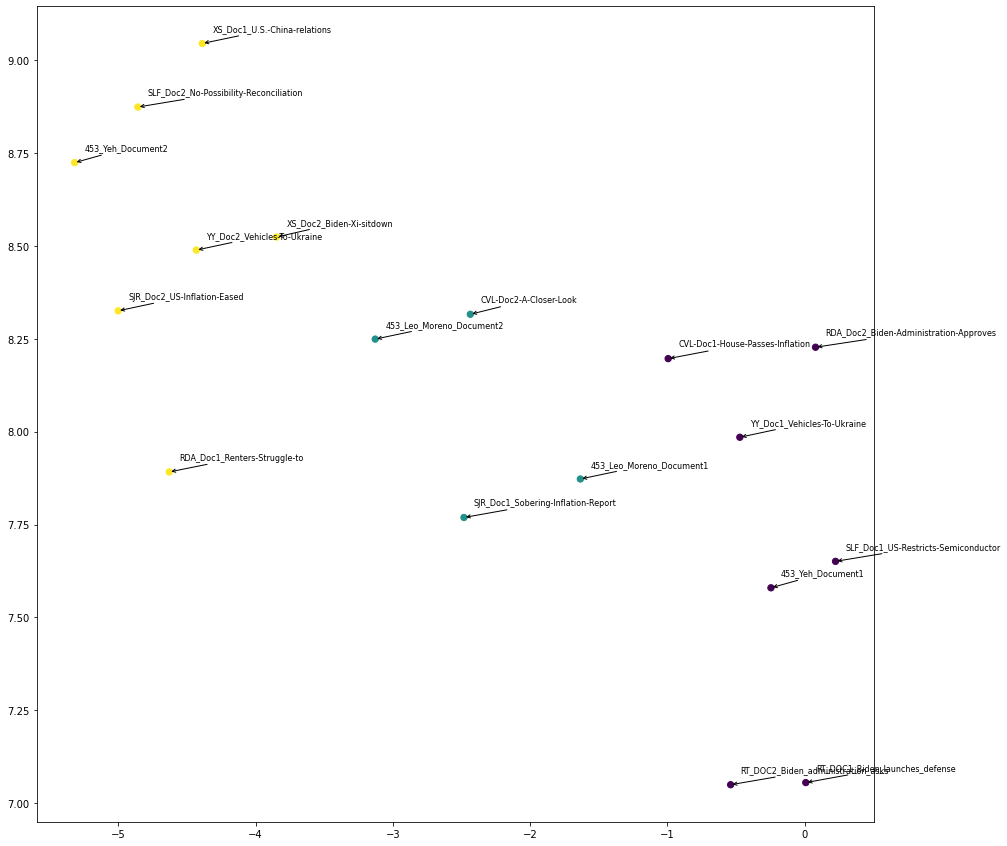

In [55]:
# Visualize the result of the doc2vec model with annotations for each point
clusters = visualize_doc2vec(model, df["filename"].tolist())

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
tfidf = TfidfVectorizer(max_df = 0.8, stop_words = 'english')
tfidf.fit(df.content)
text = tfidf.transform(df.content)

def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    cdict = dict()
    for i,r in df.iterrows():
        cdict[i] = ','.join([labels[t] for t in np.argsort(r)[-n_terms:]])

    return cdict
            
cluster_dict = get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)
cluster_df = pd.DataFrame({'cluster':labels, 'file':df.filename.tolist()}).sort_values('cluster')
cluster_df['cluster_keywords'] = cluster_df.cluster.map(cluster_dict)
cluster_df = cluster_df.reset_index(drop=True)
cluster_df

{0: 'borrowers,plan,administration,relief,debt,loan,court,student,said,ukraine',
 1: 'year,assistance,inflation,house,support,defense,mr,policies,billion,ukraine',
 2: 'prices,month,chinese,taiwan,charging,xi,said,vehicles,ukraine,china'}

In [65]:
cluster_df = pd.DataFrame({'cluster':labels, 'file':df.filename.tolist()}).sort_values('cluster')

In [68]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1
pd.options.display.width = None

In [71]:
cluster_df['cluster_keywords'] = cluster_df.cluster.map(cluster_dict)
cluster_df = cluster_df.reset_index(drop=True)
cluster_df

,cluster,file,cluster_keywords
0,0,CVL-Doc2-A-Closer-Look,"borrowers,plan,administration,relief,debt,loan,court,student,said,ukraine"
1,0,453_Leo_Moreno_Document1,"borrowers,plan,administration,relief,debt,loan,court,student,said,ukraine"
2,0,SJR_Doc1_Sobering-Inflation-Report,"borrowers,plan,administration,relief,debt,loan,court,student,said,ukraine"
3,0,453_Leo_Moreno_Document2,"borrowers,plan,administration,relief,debt,loan,court,student,said,ukraine"
4,1,SLF_Doc1_US-Restricts-Semiconductor,"year,assistance,inflation,house,support,defense,mr,policies,billion,ukraine"
5,1,453_Yeh_Document1,"year,assistance,inflation,house,support,defense,mr,policies,billion,ukraine"
6,1,YY_Doc1_Vehicles-To-Ukraine,"year,assistance,inflation,house,support,defense,mr,policies,billion,ukraine"
7,1,CVL-Doc1-House-Passes-Inflation,"year,assistance,inflation,house,support,defense,mr,policies,billion,ukraine"
8,1,RDA_Doc2_Biden-Administration-Approves,"year,assistance,inflation,house,support,defense,mr,policies,billion,ukraine"
9,1,RT_DOC2_Biden_administration_asks,"year,assistance,inflation,house,support,defense,mr,policies,billion,ukraine"


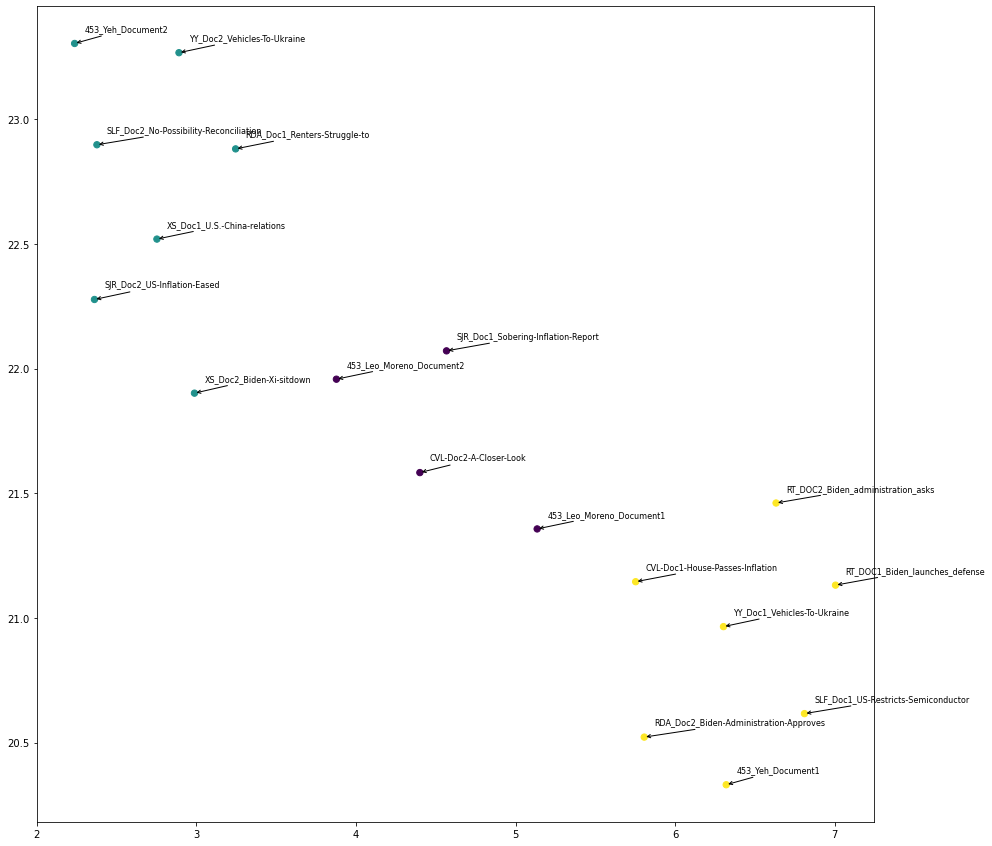

In [43]:
# Visualize the result of the doc2vec model with annotations for each point
visualize_doc2vec_model(model, df["filename"].tolist())

# Doc2Vec, PCA, KMeans

In [29]:
# Fit a doc2vec model to the documents and return the model
def fit_doc2vec_model(documents):
    tagged_docs = [TaggedDocument(words=doc.split(), tags=[idx]) for idx, doc in enumerate(documents)]
    model = Doc2Vec(tagged_docs, vector_size=100, window=2, min_count=1, workers=4)
    return model

In [30]:
# Visualize the result of the doc2vec model with annotations for each point
def visualize_doc2vec_model(model, filenames):
    X = model.docvecs.vectors_docs
    reducer = PCA(n_components=2)
    X_reduced = reducer.fit_transform(X)
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X_reduced)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, s=40)
    for i, filename in enumerate(filenames):
        ax.annotate(filename, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8,  xytext=(10, 10),
                 textcoords='offset points', ha='left', va='bottom',
                #  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    plt.show()

In [31]:
# Fit a doc2vec model to the documents
model = fit_doc2vec_model(df["content"].tolist())

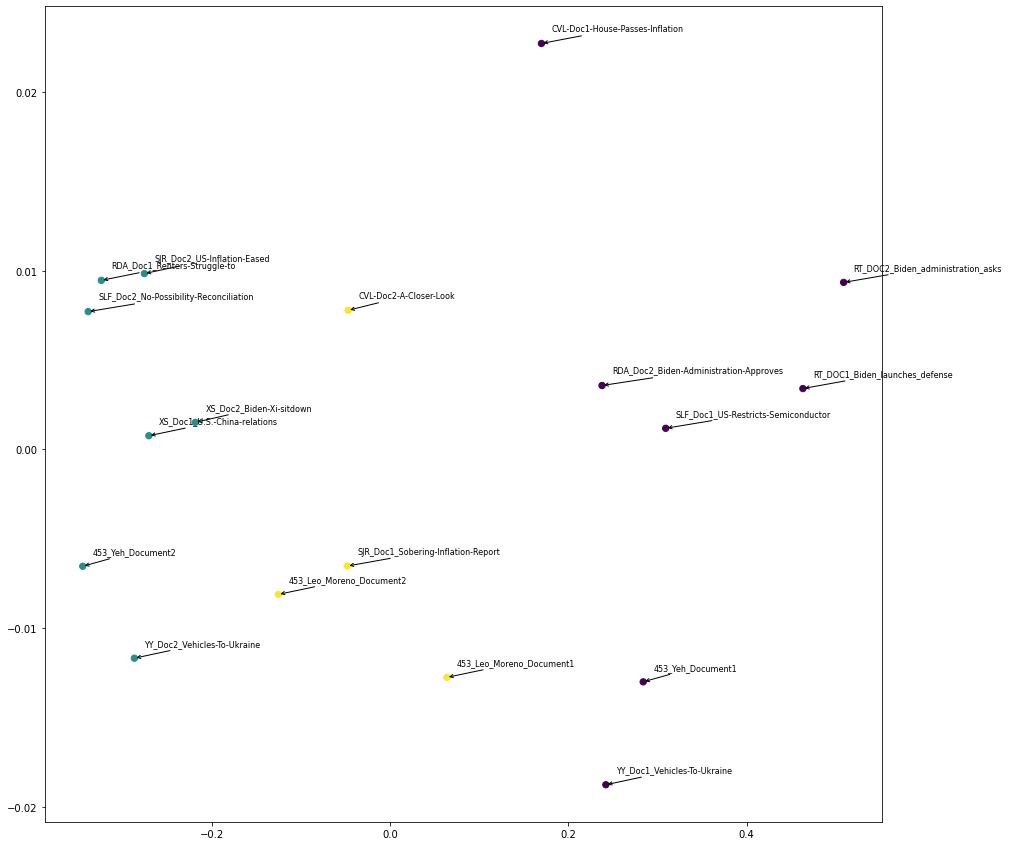

In [33]:
# Visualize the result of the doc2vec model with annotations for each point
visualize_doc2vec_model(model, df["filename"].tolist())

# TF-IDF, PCA, KMeans

In [1]:
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [8]:
tfidf = TfidfVectorizer(
    # min_df = 5,
    max_df = 0.8,
    # max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df.content)
text = tfidf.transform(df.content)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters


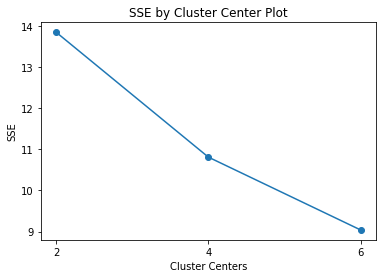

In [9]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 6)

In [10]:
clusters = MiniBatchKMeans(n_clusters=3).fit_predict(text)

In [11]:
import numpy as np

In [ ]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=18, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=2).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=18, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)